In [1]:
import os
import sys
sys.path.append('..')

from IPython.display import clear_output

import glob
import torch
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
np.seterr(divide='ignore', invalid='ignore')

from uncertain.pairwise_ranking.MF import bprMF, UncertainMF, PretrainedUncertainMF
from uncertain.pairwise_ranking.GMF import UncertainGMF
from uncertain.pairwise_ranking.GER import GER
from uncertain.extras import Resample

from uncertain.utils.data import ImplicitData as Data
from uncertain.utils.training import train, run_study, load
from uncertain.utils.evaluation_implicit import test_vanilla, test_uncertain

from matplotlib import pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
import seaborn as sns

os.chdir('New-ML_implicit')

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'MovieLens data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
else:
    data = pd.read_csv('data.csv')
    data.columns = ['user', 'item', 'score', 'timestamps']
    data = Data(data)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)
        
base_conf = {'embedding_dim':10, 'lr':0, 'weight_decay':0}
trials = 1 # Eval mode

MovieLens data prepared: 6034 users, 3125 items.
461948 train, 58117 validation and 54311 test interactions.


In [2]:
f'batch size: ({2**7}, {2**9}) - learning rate: ({1e-4}, {1e-3} - weight_decay: {1e-4, 1e-2})'

'batch size: (128, 512) - learning rate: (0.0001, 0.001 - weight_decay: (0.0001, 0.01))'

# bprMF

In [16]:
name = 'BPR'
def init_model(**kwargs):
    return bprMF(data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**7, 2**9)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'lr': trial.suggest_float('lr', 1e-4, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-4, 1e-2)}
    '''
    'weight_decay': (trial.suggest_float('wd_user', 1e-4, 1e-2), 
                     trial.suggest_float('wd_item', 1e-4, 1e-2), 
                     trial.suggest_float('wd_neg_item', 1e-4, 1e-2))
    '''
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
baseline = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(baseline, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8939441365469242, 'MAP': array([0.3447133 , 0.4231024 , 0.44707772, 0.45496815, 0.45384347,
       0.45139283, 0.44727287, 0.44223672, 0.43624264, 0.43141323],
      dtype=float32), 'Recall': array([0.03018103, 0.05517731, 0.07464466, 0.09423136, 0.11116563,
       0.12678477, 0.14067726, 0.15404423, 0.16773215, 0.18075317],
      dtype=float32)}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd_user,user_attrs_filename,state
48,48,0.481137,2022-06-19 09:46:40.383822,2022-06-19 10:05:55.121109,0 days 00:19:14.737287,476,200,0.000222,0.005538,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
43,43,0.480324,2022-06-19 08:50:38.307727,2022-06-19 09:10:17.919654,0 days 00:19:39.611927,499,200,0.000254,0.004517,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
42,42,0.476649,2022-06-19 08:32:23.189228,2022-06-19 08:50:38.306681,0 days 00:18:15.117453,369,200,0.000275,0.004841,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
0,0,0.475163,2022-06-19 01:16:33.567881,2022-06-19 01:39:39.744666,0 days 00:23:06.176785,508,200,0.000328,0.007658,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
32,32,0.474345,2022-06-19 07:07:37.202994,2022-06-19 07:21:17.206581,0 days 00:13:40.003587,476,200,0.000373,0.006811,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


# Resample

{'FCP': 0.8939441365469242,
 'CP unc': 0.19812382328129305,
 'DP unc': 0.24070381945898747,
 'PUR': 0.823102116645268,
 'corr_usup': -0.14916197988017474,
 'corr_isup': -0.17025422218148595,
 'MAP': array([0.3447133 , 0.4231024 , 0.44707772, 0.45496815, 0.45384347,
        0.45139283, 0.44727287, 0.44223672, 0.43624264, 0.43141323],
       dtype=float32),
 'Recall': array([0.03018103, 0.05517731, 0.07464466, 0.09423136, 0.11116563,
        0.12678477, 0.14067726, 0.15404423, 0.16773215, 0.18075317],
       dtype=float32),
 'URI': 0.04620879516005516,
 'UAC': -0.26926535153080255}

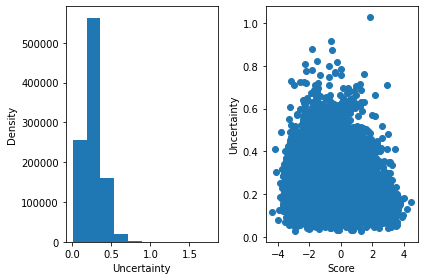

In [4]:
# Load params
best_params = study.best_params
data.batch_size = best_params['bs']
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 'weight_decay': best_params['wd_user']}

# Train
if trials > 0:
    og = deepcopy(data.train)
    for i in range(5):
        data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
        model = init_model(**best_params)
        train(model, data, path='checkpoints/resample', name=f'{i}')
    data.train = og
    
# Load resample models
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(init_model(**base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0]), models)
results_resample = test_uncertain(resample, data, name='RESAMPLE', max_k=10)
clear_output(wait=True)
results_resample

# UncertainMF

{'FCP': 0.8777595698845537, 'CP unc': 0.24034156, 'DP unc': 0.1185822, 'PUR': 2.026793, 'corr_usup': -0.29589505136151956, 'corr_isup': -0.18090652743599694, 'MAP': array([0.34570765, 0.4144846 , 0.43832177, 0.44427872, 0.44424418,
       0.4428504 , 0.43791857, 0.43296427, 0.4269703 , 0.42136645],
      dtype=float32), 'Recall': array([0.02879469, 0.05148598, 0.07191038, 0.08870856, 0.10543481,
       0.12060294, 0.13475156, 0.14718708, 0.15978496, 0.17007029],
      dtype=float32), 'URI': -0.0317104235291481, 'UAC': -0.21990893395120462}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,params_wd_user,user_attrs_filename,state
4,4,0.477629,2022-06-19 17:06:33.383257,2022-06-19 17:36:39.781624,0 days 00:30:06.398367,482,200,0.000562,NaN,0.0,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
15,15,0.471638,2022-06-19 21:05:02.227940,2022-06-19 21:49:41.285223,0 days 00:44:39.057283,342,200,0.000455,1.000000e-07,NaN,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
2,2,0.469808,2022-06-19 16:05:03.909914,2022-06-19 16:37:31.847189,0 days 00:32:27.937275,281,200,0.000615,NaN,0.0,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
14,14,0.468720,2022-06-19 20:08:43.746695,2022-06-19 21:01:48.381061,0 days 00:53:04.634366,240,200,0.000524,1.000000e-07,NaN,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
3,3,0.466685,2022-06-19 16:37:31.848241,2022-06-19 17:06:33.382096,0 days 00:29:01.533855,392,200,0.000682,NaN,0.0,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


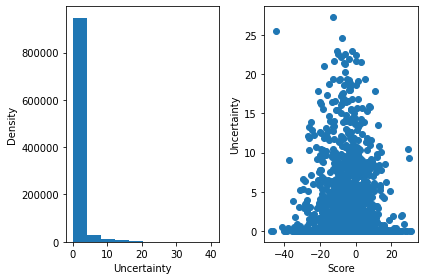

In [13]:
name = 'UncertainMF'

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**7, 2**9)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'embedding_dim_var': trial.suggest_int('dim_var', 200, 200),
              'lr': trial.suggest_float('lr', 1e-4, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 0)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = UncertainMF(data.n_user, data.n_item, **params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

In [7]:
model.recommend(0, n=100000)

,scores,uncertainties
74,21.612497,1.496916e+01
6,20.762112,1.984149e-08
270,20.400642,1.491410e-04
34,19.707624,8.833395e-11
117,19.469862,3.411064e-11
...,...,...
2897,-30.508614,8.893779e-08
3097,-30.859663,1.144802e-01
3055,-33.808792,1.948684e+01
3011,-37.901291,9.189728e-11


{'FCP': 0.8794903426561839, 'CP unc': 0.2212244, 'DP unc': 0.19206987, 'PUR': 1.1517912, 'corr_usup': -0.29044927520455427, 'corr_isup': -0.23512287149868433, 'MAP': array([0.35266823, 0.42442825, 0.44959122, 0.4545446 , 0.4520532 ,
       0.44700256, 0.4431107 , 0.43855488, 0.43374014, 0.42761454],
      dtype=float32), 'Recall': array([0.03098841, 0.05589934, 0.07567828, 0.09165872, 0.10616264,
       0.12080458, 0.13372095, 0.14592348, 0.15652058, 0.16825587],
      dtype=float32), 'URI': -0.004332353826612234, 'UAC': -0.23705324170153513}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_dim_var,params_lr,params_wd,user_attrs_filename,state
0,0,0.474252,2022-06-21 09:50:59.879302,2022-06-21 10:51:58.587661,0 days 01:00:58.708359,156,200,10,0.000301,6.346564e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
1,1,0.287736,2022-06-21 10:51:58.588468,2022-06-21 10:55:24.582743,0 days 00:03:25.994275,150,200,10,0.000936,8.067078e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


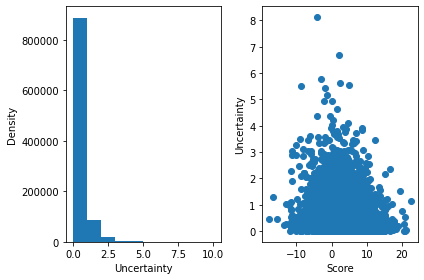

In [2]:
name = 'UncertainMF2'

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**7, 2**9)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'embedding_dim_var': trial.suggest_int('dim_var', 200, 200),
              'lr': trial.suggest_float('lr', 1e-4, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 0)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = UncertainMF(data.n_user, data.n_item, **params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1, 1).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

In [4]:
model.recommend(0, n=100000)

,scores,uncertainties
117,14.366136,0.140730
175,12.957953,1.098552
6,12.812931,0.037385
37,12.781489,0.239953
74,12.525930,0.871396
...,...,...
2146,-9.098774,0.009599
3111,-10.302203,0.372509
3011,-11.049710,0.370023
3055,-11.413324,2.277917


{'FCP': 0.8820680893373349, 'CP unc': 0.0049681594, 'DP unc': 0.008384896, 'PUR': 0.5925129, 'corr_usup': -0.16417715273115446, 'corr_isup': -0.7356057479509671, 'MAP': array([0.31786543, 0.38796818, 0.4103138 , 0.41762418, 0.4188796 ,
       0.4162851 , 0.41261974, 0.40870893, 0.40356955, 0.39939088],
      dtype=float32), 'Recall': array([0.02459064, 0.04670402, 0.06518729, 0.08088358, 0.09542624,
       0.10850004, 0.12202004, 0.13421334, 0.14396825, 0.15474601],
      dtype=float32), 'URI': 0.0014395816251635551, 'UAC': -0.12561137213565998}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_dim_var,params_lr,params_wd,user_attrs_filename,state
11,11,0.458267,2022-06-22 01:25:47.384431,2022-06-22 01:51:49.739721,0 days 00:26:02.355290,380,200,10,0.000393,5.233572e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
23,23,0.451378,2022-06-22 11:11:28.810777,2022-06-22 11:45:10.290669,0 days 00:33:41.479892,495,200,10,0.000247,9.636218e-06,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
13,13,0.448920,2022-06-22 02:16:16.133489,2022-06-22 02:39:20.856316,0 days 00:23:04.722827,512,200,10,0.000331,4.882606e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
16,16,0.447101,2022-06-22 03:28:08.915101,2022-06-22 03:46:59.299415,0 days 00:18:50.384314,479,200,10,0.000409,5.995110e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
4,4,0.446959,2022-06-21 22:57:24.904496,2022-06-21 23:22:39.207103,0 days 00:25:14.302607,415,200,10,0.000309,7.902140e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


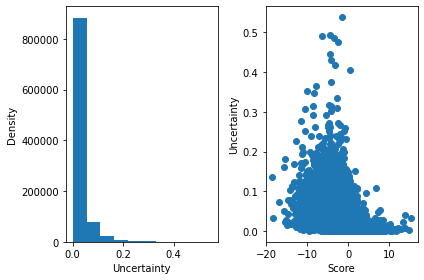

In [13]:
name = 'UncertainMF3'

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**7, 2**9)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'embedding_dim_var': trial.suggest_int('dim_var', 200, 200),
              'lr': trial.suggest_float('lr', 1e-4, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 0)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = UncertainMF(data.n_user, data.n_item, **params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1, 1).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

In [14]:
model.recommend(0, n=100000)

,scores,uncertainties
117,4.779490,0.012699
265,4.657428,0.082158
74,4.600782,0.050300
37,4.452468,0.054205
468,4.340460,0.095146
...,...,...
3008,-5.998253,0.258563
3097,-6.144778,0.195557
3111,-6.557135,0.186812
2396,-6.663690,0.090169


{'FCP': 0.8810001657122867, 'CP unc': 0.029719358, 'DP unc': 0.041729476, 'PUR': 0.71219105, 'corr_usup': -0.13761279949811697, 'corr_isup': -0.8899482657927557, 'MAP': array([0.33742127, 0.4066954 , 0.4280743 , 0.43449157, 0.43620825,
       0.43332866, 0.42856285, 0.4241201 , 0.41955906, 0.41419524],
      dtype=float32), 'Recall': array([0.02704076, 0.04884388, 0.06764581, 0.08566272, 0.10360911,
       0.11821237, 0.13087545, 0.1429333 , 0.15539016, 0.16647352],
      dtype=float32), 'URI': -0.06893620640039444, 'UAC': -0.16799951290613077}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_dim_var,params_lr,params_wd,user_attrs_filename,state
0,0,0.463713,2022-06-21 20:27:09.124289,2022-06-21 20:40:07.530187,0 days 00:12:58.405898,461,200,2,0.000445,5.580223e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
1,1,0.441781,2022-06-21 20:40:07.531004,2022-06-21 20:48:41.859493,0 days 00:08:34.328489,328,200,2,0.000906,7.793840e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


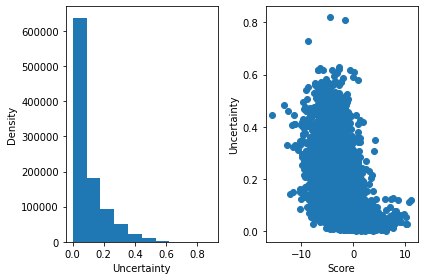

In [11]:
name = 'UncertainMF4'

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**7, 2**9)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'embedding_dim_var': trial.suggest_int('dim_var', 200, 200),
              'lr': trial.suggest_float('lr', 1e-4, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 0)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = UncertainMF(data.n_user, data.n_item, **params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1, 1).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

In [12]:
model.recommend(0, n=100000)

,scores,uncertainties
74,7.961601,0.099470
34,7.838652,0.068062
117,7.590200,0.055933
6,7.186134,0.045061
270,7.075949,0.051354
...,...,...
2480,-8.584587,0.321496
2146,-8.610759,0.291827
3031,-9.163054,0.379411
3055,-9.675627,0.425674


# PretrainedUncertainMF

{'FCP': 0.8939441365469242, 'CP unc': 0.004517967, 'DP unc': 0.009389451, 'PUR': 0.48117477, 'corr_usup': -0.360382418437121, 'corr_isup': -0.7029671360381021, 'MAP': array([0.3447133 , 0.4231024 , 0.44707772, 0.45496815, 0.45384347,
       0.45139283, 0.44727287, 0.44223672, 0.43624264, 0.43141323],
      dtype=float32), 'Recall': array([0.03018103, 0.05517731, 0.07464466, 0.09423136, 0.11116563,
       0.12678477, 0.14067726, 0.15404423, 0.16773215, 0.18075317],
      dtype=float32), 'URI': 0.02846614271402359, 'UAC': -0.2834956631440073}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
1,1,0.924061,2022-06-22 16:28:07.537652,2022-06-22 16:31:58.132484,0 days 00:03:50.594832,384,200,0.000355,0.0,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
0,0,0.481137,2022-06-22 16:04:43.721470,2022-06-22 16:07:53.886255,0 days 00:03:10.164785,304,200,0.000474,0.0,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


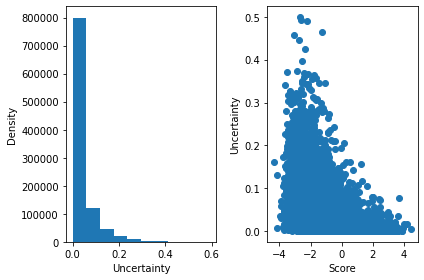

In [17]:
name = 'PretrainedUncertainMF'

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**7, 2**9)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'lr': trial.suggest_float('lr', 1e-4, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 0)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = PretrainedUncertainMF(baseline, **params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = PretrainedUncertainMF(baseline, 1, 1, 1).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

In [18]:
model.recommend(0, n=100000)

,scores,uncertainties
117,4.178872,0.004354
34,4.145980,0.019668
265,4.057560,0.017983
468,4.055206,0.006386
270,4.045223,0.003996
...,...,...
2556,-3.888273,0.043755
2855,-3.950065,0.190508
3055,-3.986200,0.241401
3078,-4.004805,0.068683


# UncertainGMF

{'FCP': 0.8848851982103073, 'CP unc': 0.0217992, 'DP unc': 0.29822302, 'PUR': 0.07309697, 'corr_usup': -0.05957498293254365, 'corr_isup': -0.7302113214023879, 'MAP': array([0.28538284, 0.3549884 , 0.38075906, 0.3879774 , 0.38966736,
       0.3888778 , 0.38624662, 0.38265404, 0.3788603 , 0.37418723],
      dtype=float32), 'Recall': array([0.02239113, 0.0416786 , 0.05750315, 0.07162291, 0.08527163,
       0.09728593, 0.10846983, 0.11970846, 0.13056877, 0.14198363],
      dtype=float32), 'URI': 0.14375856518745422, 'UAC': -0.2933035621765638}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
0,0,0.442356,2022-06-19 22:55:09.988959,2022-06-19 23:08:07.180260,0 days 00:12:57.191301,192,200,0.000665,4.776463e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
1,1,0.422252,2022-06-19 23:08:07.181238,2022-06-19 23:21:12.525760,0 days 00:13:05.344522,192,200,0.000981,7.181402e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
8,8,0.416106,2022-06-20 06:43:02.403750,2022-06-20 06:56:04.278310,0 days 00:13:01.874560,387,200,0.000292,4.382289e-06,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
5,5,0.412050,2022-06-20 06:11:17.961486,2022-06-20 06:27:44.574198,0 days 00:16:26.612712,230,200,0.000403,9.724037e-06,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
4,4,0.411646,2022-06-20 00:21:05.332621,2022-06-20 00:36:10.793946,0 days 00:15:05.461325,312,200,0.000198,3.445135e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


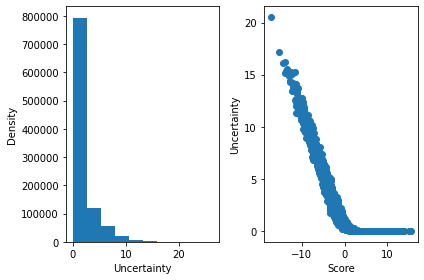

In [8]:
name = 'UncertainGMF'
def init_model(**kwargs):
    return UncertainGMF(data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**7, 2**9)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'lr': trial.suggest_float('lr', 5e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-5)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[2])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

In [9]:
model.recommend(0, n=100000)

,scores,uncertainties
664,7.484789,0.000165
265,7.348549,0.000152
163,7.072670,0.000287
468,6.971340,0.000292
498,6.929533,0.000422
...,...,...
3076,-8.083418,8.766857
2962,-8.186998,9.078764
3011,-8.463034,9.778828
3031,-8.835089,10.058745


# Results

In [10]:
# Load results
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['BPR', 'RESAMPLE', 'UncertainMF', 'UncertainGMF', 'PretrainedUncertainMF']
results = pd.DataFrame([results[key] for key in order], index=order)

# Plot aestetics
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r']
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*']
lines = {k: '-' + l for k, l, in zip(results, lines)}

# Results
results[['FCP', 'CP unc', 'DP unc', 'PUR', 'URI', 'UAC']]

,FCP,CP unc,DP unc,PUR,URI,UAC
BPR,0.893944,NaN,NaN,NaN,NaN,NaN
RESAMPLE,0.893944,0.198124,0.240704,0.823102,0.046209,-0.269265
UncertainMF,0.877760,0.240342,0.118582,2.026793,-0.031710,-0.219909
UncertainGMF,0.884885,0.021799,0.298223,0.073097,0.143759,-0.293304
PretrainedUncertainMF,0.893944,0.004518,0.009389,0.481175,0.028466,-0.283496


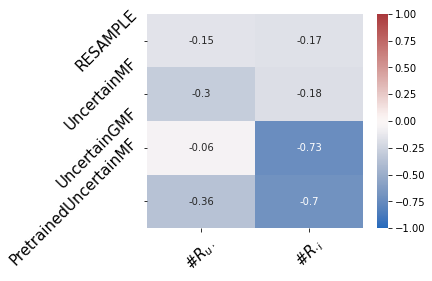

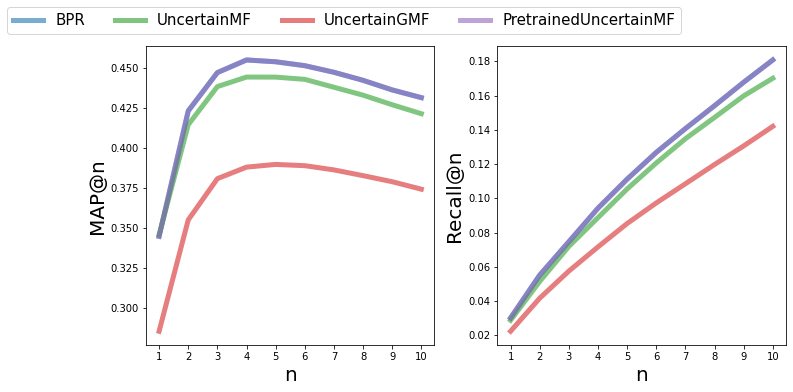

In [11]:
## Correlation plot
corr = results.drop('BPR', axis=0).filter(like='corr', axis=1)
corr.columns = [r'#$R_{u\cdot}$', r'#$R_{\cdot i}$']
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45, fontsize=15)
plt.yticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(10, 5), ncols=2)
for index, row in results.drop('RESAMPLE', axis=0).iterrows():
    ax[0].plot(np.arange(1, 11), row['MAP'], '-', color=colors[index], label=index, linewidth=5, alpha=0.6)
    ax[1].plot(np.arange(1, 11), row['Recall'], '-', color=colors[index], label=index, linewidth=5, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=len(results), bbox_to_anchor=(0.85, 1.1))
f.tight_layout()
f.savefig('plots/accuracy.pdf')